<a href="https://colab.research.google.com/github/Mateusz-best-creator/Learning_ML/blob/main/Book_Chapter_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision With TensorFlow

## Convolutional layers with keras

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255.)(images)
images.shape

TensorShape([2, 70, 120, 3])

In [2]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [3]:
conv_layer = tf.keras.layers.Conv2D(filters=32,
                                    kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

## Pooling Layers

In [4]:
# Example of pooling layer
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

class DepthPool(tf.keras.layers.Layer):

  def __init__(self,
               pool_size=2,
               **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size

  def call(self, inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size
    new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
    return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [5]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

In [6]:
images.shape

TensorShape([2, 70, 120, 3])

## `partial` function

In [7]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,
                          activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128,
                          activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])
model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

## Implementing `ResNet` using keras

In [8]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3,
                        strides=1,
                        padding="same",
                        kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):

  def __init__(self,
               filters,
               strides=1,
               activation="relu",
               **kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [DefaultConv2D(filters, strides=strides),
                        tf.keras.layers.BatchNormalization(),
                        self.activation,
                        DefaultConv2D(filters),
                        tf.keras.layers.BatchNormalization(),
                        ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [DefaultConv2D(filters, kernel_size=1, strides=strides),
                          tf.keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])
prev_filters=64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if prev_filters == filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

# Final layers for classification
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [9]:
for layer in model.layers:
  print(layer.name)

conv2d_7
batch_normalization
activation
max_pooling2d_4
residual_unit
residual_unit_1
residual_unit_2
residual_unit_3
residual_unit_4
residual_unit_5
residual_unit_6
residual_unit_7
residual_unit_8
residual_unit_9
residual_unit_10
residual_unit_11
residual_unit_12
residual_unit_13
residual_unit_14
residual_unit_15
global_average_pooling2d_1
flatten_1
dense_3


## Pretrained models from keras

In [10]:
model = tf.keras.applications.ResNet50(weights="imagenet")
images = load_sample_images()["images"]
images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
images_resized = tf.keras.layers.Resizing(height=224,
                                          width=224,
                                          crop_to_aspect_ratio=True)(images_tensor)
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)
Y_proba = model.predict(inputs)
Y_proba.shape

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


(2, 1000)

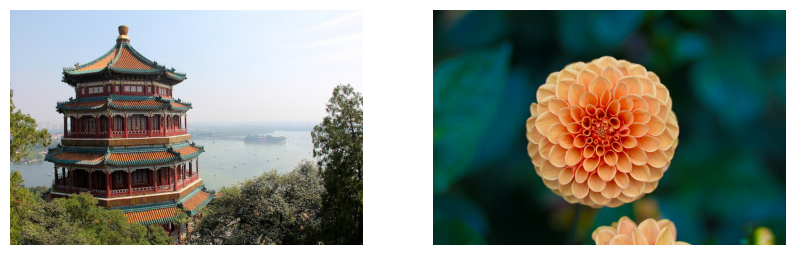

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(images[0])
axes[0].axis('off')
axes[1].imshow(images[1])
axes[1].axis('off')
plt.show()

In [12]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print(f"Image #{image_index}")
  for class_id, name, y_proba in top_K[image_index]:
    print(f"  {class_id} - {name} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
  n03877845 - palace 54.69%
  n03781244 - monastery 24.71%
  n02825657 - bell_cote 18.55%
Image #1
  n04522168 - vase 32.67%
  n11939491 - daisy 17.82%
  n03530642 - honeycomb 12.04%


## Pretrained models

In [13]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

dataset_size, class_names, n_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

In [14]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers",
                                                       split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
                                                       as_supervised=True)
batch_size=32
preprocess = tf.keras.Sequential([tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
                                  tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [15]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
                                         tf.keras.layers.RandomRotation(factor=0.05, seed=42),
                                         tf.keras.layers.RandomContrast(factor=0.2, seed=42)])

In [16]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=3)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.7001 - loss: 1.0475 - val_accuracy: 0.8149 - val_loss: 0.6935
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9048 - loss: 0.4418 - val_accuracy: 0.8348 - val_loss: 0.7149
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.9436 - loss: 0.1696 - val_accuracy: 0.8675 - val_loss: 0.5634


In [16]:
# Unfreeze the layers
for layer in base_model.layers[56:]:
  layer.trainable=True

optimizer_2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer_2,
              metrics=["accuracy"])
history_2 = model.fit(train_set,
                      validation_data=valid_set,
                      epochs=3)

## Classification and localization

To predict a bounding box around the object, we can predict horizontal andvertical coordinates of the objects center, as well as it's height and width.

In [18]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
localization_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=(class_output, localization_output))
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer,
              metrics=["accuracy"])